In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
from time_domain_astronomy_sandbox.backend import Backend
from time_domain_astronomy_sandbox.observation import Observation
from time_domain_astronomy_sandbox.pulse import Pulse
from time_domain_astronomy_sandbox.plotting import plot_multi_images, plot_multi_1D
from time_domain_astronomy_sandbox.rfim import RFIm

import copy
import numpy as np
from matplotlib import rc

# Dispersed pulse covering all of ARTS band

In [ ]:
def interactive_pulse_arts():
    """Plot interactive dispersed pulse using ASTRON's ARTS backend."""
    pulse = Pulse(Backend())
    pulse.plot_delay_v_frequency_interactive(xscale='linear')

interactive_pulse_arts()

# Dispersed pulse from ARTS band to LOFAR HBA band

In [ ]:
def interactive_pulse_arts_to_lofar_hba():
    """Plot interactive dispersed pulse using bands from ARTS to Lofar HBA."""
    fmin = 120
    n_channels = 3000
    channel_bandwidth = (Backend().fmax-fmin)/n_channels

    pulse = Pulse(
        Backend(
            fmin=fmin,
            n_channels=n_channels,
            channel_bandwidth=channel_bandwidth
            )
        )
    pulse.plot_delay_v_frequency_interactive(xscale='linear', dm_init=3000)

interactive_pulse_arts_to_lofar_hba()

# Make incoherent de-dispersion explanation plot

In [ ]:
Pulse().plot_signal_dispersed_dedispersed(dm=3000)

# Add one dispersed pulse, and dedisperse it.

In [ ]:
def test_one_pulse_dedisperse():
    """Plot one dispersed pulse, and it's dedispersed self."""
    obs = Observation(Backend(), length=1.5*1.024)
    noise_window = obs.window.copy()
    obs.add_dispersed_pulse(dm=1000, width=0.006, pulse_t0=0.16, snr=20, verbose=True)
    xstep = 1000
    ystep = 500

    rc('font', size=12)
    rc('axes', titlesize=12)
    rc('axes', labelsize=12)

    plot_multi_images(
        (
            noise_window,
            obs.window,
            obs.dedisperse(dm=1000),
        ),
        
        labels=(
            'Noise (gaussian)',
            u'Noise + Faint FRB',
            'Noise + Faint FRB (Dedispersed at DM=3000 pc/cm^3)',
        ),
        
        direction='vertical',

        xticks=obs.time_indices[::xstep],
        xtick_labels=["%.2f" % t for t in obs.times[::xstep]],

        yticks=obs.backend.freq_indices[::ystep],
        ytick_labels=["%.0f" % f for f in obs.backend.frequencies[::ystep]],

        xfig_size = 15,
        yfig_size = 5,
#         spectrum=True    # experimental viz
        
        savefig='pulse',
        ext='png'
        
    )
    
    print(obs.window.min(), obs.window.max(), obs.window.mean(), obs.window.std())

test_one_pulse_dedisperse()

# Add 2 low DM pulses, 1 high DM pulse, and periodic narrow band RFI 
## + RFI cleaning

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


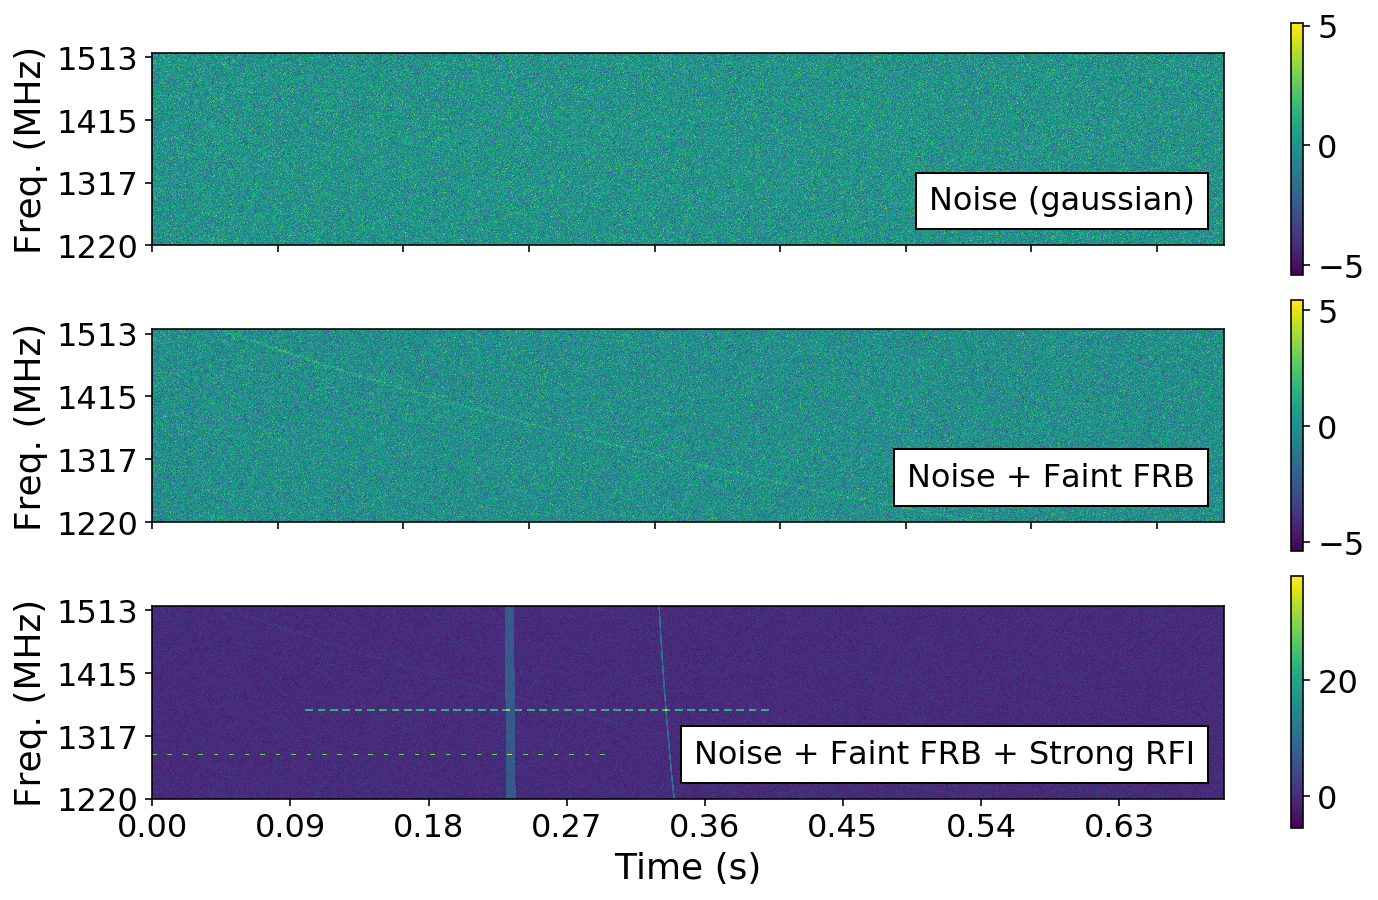

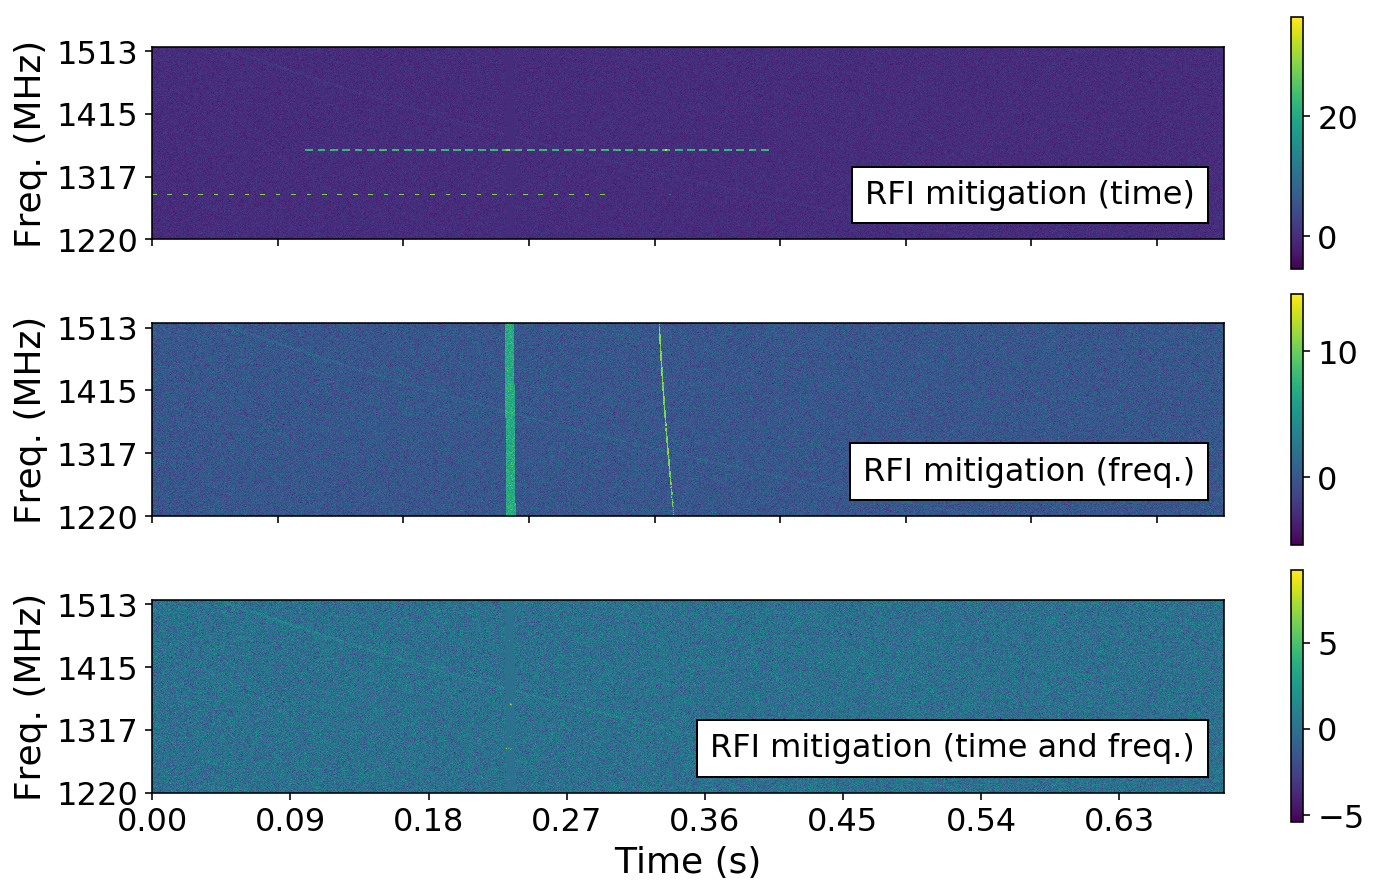

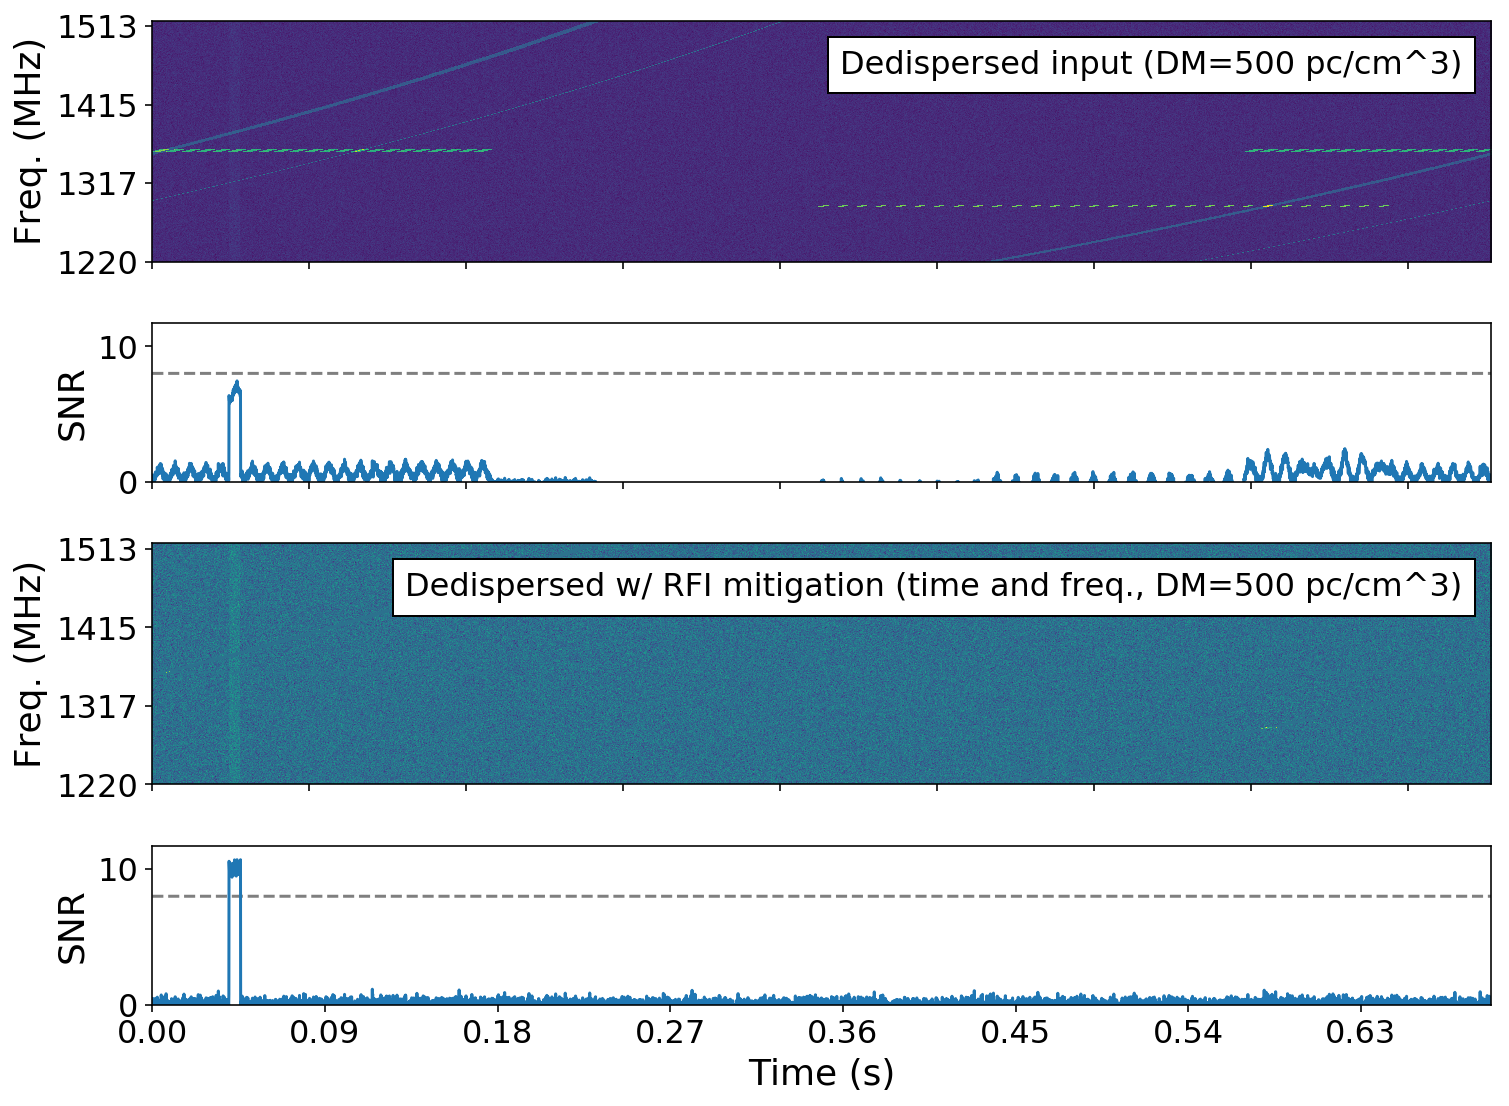

In [5]:
def pulse_and_rfi__cleaned():
    obs = Observation(Backend(), length=1.024/1.5)
    raw = obs.window.copy()
    obs.add_dispersed_pulse(dm=500, width=0.006, pulse_t0=0.04, snr=15)
    frb = obs.window.copy()
    obs.add_dispersed_pulse(dm=1, width=0.006, pulse_t0=0.23, snr=125)
    obs.add_dispersed_pulse(dm=10, width=0.001, pulse_t0=0.33, snr=125)

    for t_start, t_step, t_width, f1, f2 in [
        [0., 0.01, 0.003, 350, 360], 
        [0.1, 0.008, 0.005, 700, 715], 
    #     [0.2, 0.007, 0.004, 1220, 1255]
    ]:
        obs.add_rfi(
            t_start=t_start,
            t_stop=t_start+0.3,
            t_step=t_step,
            t_width=t_width,

            f_start=f1, 
            f_stop=f2,

            snr=125,
        )

    xstep = 1100
    ystep = 500

    rc('font', size=16)
    rc('axes', labelsize=18)

    original = copy.deepcopy(obs)

    plot_multi_images(
        (
            raw,
            frb,
            original.window,
        ),

        labels=(
            'Noise (gaussian)',
            'Noise + Faint FRB',
            'Noise + Faint FRB + Strong RFI',
        ),

        direction='vertical',

        xticks=obs.time_indices[::xstep],
        xtick_labels=["%.2f" % t for t in obs.times[::xstep]],

        yticks=obs.backend.freq_indices[::ystep],
        ytick_labels=["%.0f" % f for f in obs.backend.frequencies[::ystep]],

        xfig_size=12,
        yfig_size=7.4,
        spectrum=False,
        colorbar=True,
        savefig=True,
        fig_name='noise_pulses_rfi',
        ext='pdf'
    )
    
    del raw

    o_tc = RFIm().tdsc_amber(obs.window.copy())
    o_fc = RFIm().fdsc_amber(obs.window.copy(), bin_size=Backend().n_channels, threshold=3.25)
    plot_multi_images(
        (
            o_tc,
            o_fc,
            obs.frequency_cleaning(obs.time_cleaning(), keep_state=True, bin_size=Backend().n_channels, threshold=3.25),
        ),

        labels=(
            'RFI mitigation (time)',
            'RFI mitigation (freq.)',
            'RFI mitigation (time and freq.)',
        ),

        direction='vertical',

        xticks=obs.time_indices[::xstep],
        xtick_labels=["%.2f" % t for t in obs.times[::xstep]],

        yticks=obs.backend.freq_indices[::ystep],
        ytick_labels=["%.0f" % f for f in obs.backend.frequencies[::ystep]],

        xfig_size=12,
        yfig_size=7.4,
        spectrum=False,
        colorbar=True,
        savefig=True,
        fig_name='rficlean',
        ext='pdf'
    )
    
    plot_multi_images(
        (
#             original.window,
            original.dedisperse(dm=500),
            obs.dedisperse(dm=500),
        ),

        labels=(
#             'Input (Noise + Faint FRB + Strong RFI)',
            'Dedispersed input (DM=500 pc/cm^3)',
            'Dedispersed w/ RFI mitigation (time and freq., DM=500 pc/cm^3)',
        ),

        direction='vertical',

        xticks=obs.time_indices[::xstep],
        xtick_labels=["%.2f" % t for t in obs.times[::xstep]],

        yticks=obs.backend.freq_indices[::ystep],
        ytick_labels=["%.0f" % f for f in obs.backend.frequencies[::ystep]],

        xfig_size=12,
        yfig_size=9.4,
        
        loc=1,
        
        detection_threshold=8.,
        
        spectrum=True,
        colorbar=False,
        savefig=True,
        fig_name='input_dedispersed',
        ext='pdf'
    )
    
pulse_and_rfi__cleaned()

In [ ]:
def pulse_and_rfi__cleaned():
    obs = Observation(Backend(), length=1.024*1.3)
    raw = obs.window.copy()
#     obs.add_dispersed_pulse(dm=500, width=0.006, pulse_t0=0.04, snr=9)
    frb = obs.window.copy()
#     obs.add_dispersed_pulse(dm=1, width=0.006, pulse_t0=0.23, snr=125)
    obs.add_dispersed_pulse(dm=90, width=0.03, pulse_t0=0.65, snr=250)

#     for t_start, t_step, t_width, f1, f2 in [
#         [0., 0.01, 0.003, 350, 360], 
#         [0.1, 0.008, 0.005, 700, 715], 
#     #     [0.2, 0.007, 0.004, 1220, 1255]
#     ]:
#         obs.add_rfi(
#             t_start=t_start,
#             t_stop=t_start+0.3,
#             t_step=t_step,
#             t_width=t_width,

#             f_start=f1, 
#             f_stop=f2,

#             snr=125,
#         )

    xstep = 1100
    ystep = 500

    rc('font', size=16)
    rc('axes', labelsize=18)

    original = copy.deepcopy(obs)
    dm0 = copy.deepcopy(obs)

#     plot_multi_images(
#         (
#             raw,
#             frb,
#             original.window,
#         ),

#         labels=(
#             'Noise (gaussian)',
#             'Noise + Faint FRB',
#             'Noise + Faint FRB + Strong RFI',
#         ),

#         direction='vertical',

#         xticks=obs.time_indices[::xstep],
#         xtick_labels=["%.2f" % t for t in obs.times[::xstep]],

#         yticks=obs.backend.freq_indices[::ystep],
#         ytick_labels=["%.0f" % f for f in obs.backend.frequencies[::ystep]],

#         xfig_size=12,
#         yfig_size=7.4,
#         spectrum=False,
#         colorbar=False,
#         savefig=True,
#         fig_name='noise_pulses_rfi',
#         ext='png'
#     )
    
    del raw

    o_tc = RFIm().tdsc_amber(obs.window.copy())
    o_fc = RFIm().fdsc_amber(obs.window.copy(), bin_size=Backend().n_channels, threshold=3.25)
    o_dm0 = RFIm().dm0clean(obs.window.copy())
#     plot_multi_images(
#         (
#             original.window,
#             o_tc,
#             o_fc,
#             obs.frequency_cleaning(obs.time_cleaning(), keep_state=True, bin_size=Backend().n_channels, threshold=3.25),
#             o_dm0
#         ),

#         labels=(
#             'Pulse DM=90, SNR=10.1',
#             'RFI mitigation (time)',
#             'RFI mitigation (freq.)',
#             'RFI mitigation (time and freq.)',
#             'DM0 cleaning'
#         ),

#         direction='vertical',

#         xticks=obs.time_indices[::xstep],
#         xtick_labels=["%.2f" % t for t in obs.times[::xstep]],

#         yticks=obs.backend.freq_indices[::ystep],
#         ytick_labels=["%.0f" % f for f in obs.backend.frequencies[::ystep]],

#         xfig_size=12,
#         yfig_size=10.4,
#         spectrum=False,
#         colorbar=False,
#         savefig=True,
#         fig_name='rficlean',
#         ext='png'
#     )
    obs.frequency_cleaning(obs.time_cleaning(), keep_state=True, bin_size=Backend().n_channels, threshold=3.25),
    dm0.dm0_cleaning(keep_state=True)
    
    plot_multi_images(
        (
#             original.window,
            original.window,
            o_tc,
            o_fc,
            obs.window,
            o_dm0,
            original.dedisperse(dm=90),
            obs.dedisperse(dm=90),
            dm0.dedisperse(dm=90),
        ),

        labels=(
#             'Input (Noise + Faint FRB + Strong RFI)',
            'Pulse DM=90',
            'RFI mitigation (time)',
            'RFI mitigation (freq.)',
            'RFI mitigation (time and freq.)',
            'DM0 cleaning',
            'Dedispersed input (DM=90 pc/cm^3)',
            'Dedispersed w/ RFI mitigation (time and freq.)',
            'Dedispersed w/ RFI mitigation (DM0 clean)',
        ),

        direction='vertical',

        xticks=obs.time_indices[::xstep],
        xtick_labels=["%.2f" % t for t in obs.times[::xstep]],

        yticks=obs.backend.freq_indices[::ystep],
        ytick_labels=["%.0f" % f for f in obs.backend.frequencies[::ystep]],

        xfig_size=12,
        yfig_size=20.4,
        
        loc=1,
        
        detection_threshold=8.,
        
        spectrum=True,
        colorbar=False,
        savefig=True,
        fig_name='input_dedispersed',
        ext='png'
    )
    
pulse_and_rfi__cleaned()